# Focusing on the whole SPIDER (using fixed cube)

________________________________________________________________________________________________________________________

## Import all python libraries

Here, I am importing all python libraries I will be using

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ROHSApy import ROHSA
from scipy.optimize import curve_fit
import random

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter

from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.convolution import Gaussian2DKernel
from scipy.signal import convolve as scipy_convolve
from astropy.convolution import convolve

from skimage import data
from skimage.restoration import inpaint

## Download the cube data

The first thing I need to do is download the data cube. I went to the address: https://www.cita.utoronto.ca/GHIGLS/ to download the data cube. The designated region I am working with is the SPIDER region. 

In [2]:
#!wget https://www.cita.utoronto.ca/GHIGLS/FITS/GHIGLS_SPIDER_Tb.fits

I am also installing ROHSApy.

In [3]:
#!pip install ROHSApy

## Load the data cube

inpainted cube (new cube)

In [4]:
# Now I need to load the data cube that I collected in the above step.
fitsname = "GHIGLS_NCPL_Tb.fits"
hdu = fits.open(fitsname)
hdr = hdu[0].header
cube = hdu[0].data[0][:,:,:]
# In the PPV cube, there are 3 axes (Representing the three spaces in the list).
# The first is the velocity axis. The others represent the position coordinates, x and y.

In order to get the axis to be in units of velocity, need this function which converts pixel units to velocity (km/s)

In [6]:
def spec_2_velocity(CRVAL, CDELT, CRPIX, index):
    '''
    Description: 
        This function takes in the parameters from the header and adjusts the \
        velocity range so that is centers at zero (based on the reference). 
    
    Parameters:
        CRVAL - The value of the reference velocity - float
        CDELT - The value of the channel spacing - float
        CRPIX - The value of the pixel where CRVAL occurs - float
    
    Returns:
        This function returns the adjusted velocity list - list
    '''
    vel = [(CRVAL + CDELT * (index[i] - CRPIX)) for i in range(len(index))]
    # Puts in units of km/s
    
    return vel

In [7]:
index_arr = np.arange(cube.shape[0])

cdelt3 = hdr["CDELT3"]/1000. #This allows it to be in units of km/s rather than m/s
crpix3 = hdr["CRPIX3"]
crval3 = hdr["CRVAL3"]/1000. #This allows it to be in units of km/s rather than m/s

vel = np.array(spec_2_velocity(crval3,cdelt3,crpix3,index_arr))

## Function for producing Gaussians

Here, I define a function for a gaussian function. I will be plotting some gaussians manually, so I need this function for later

In [8]:
# Some constants for the integrals:
dv = abs(cdelt3)
C = 1.82243e18

In [9]:
# Function for a single Gaussian 
def one_gauss_func(x, amp, cent, sigma):
    '''
    Description: 
        Evaluates a Gaussian function given some parameters
    
    Parameters:
        x - Value at which the Gaussian is evaluated at - float
        amp - The amplitude of the Gaussian - float
        cent - The location of the of the peak - float 
        sigma - The width of the peak - float
    
    Returns:
        The function evaluated at x - float
    '''
    return amp*np.exp(-(x-cent)**2/(2*sigma**2))

## Interpolating the galaxy and masked regions

First look at the column density map to find the areas to be fixed

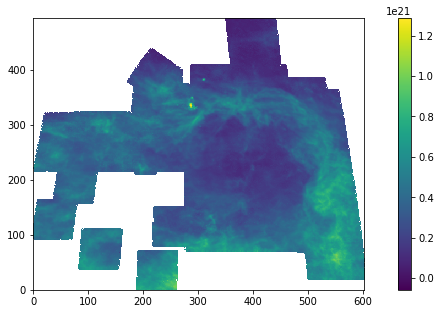

In [10]:
plt.figure(figsize=(12,5)) ; plt.imshow(np.sum(cube, 0)*C*dv, origin='lower') ; plt.colorbar()

Now, we can set the nan's to zero also take a small 256x256 region for ROHSA

In [11]:
# To fix the nan's, I need to set them to zero for ROHSA 
cube[cube != cube] = 0

(256, 256)


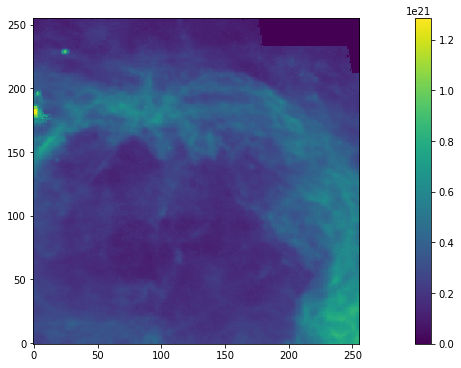

In [12]:
fig = plt.figure(figsize=(20,6))
y_corner = 410 ; x_corner = 285
subcube_NCPL = cube[:, y_corner-256:y_corner, x_corner:x_corner+256]
plt.imshow(np.sum(subcube_NCPL, 0)*C*dv, origin='lower') ; plt.colorbar()
print(np.sum(subcube_NCPL, 0).shape)
fig.savefig("Initial_map_of_SPIDER_and_NCPL.pdf", bbox_inches='tight')

## Using Inpainting

In [13]:
image_orig = subcube_NCPL.T
# Need to transpose in order to get the the vel axis as the final index
#(as in the example), but this does not change the data.

# Create mask with the defect regions that need to be "fixed"
mask = np.zeros(image_orig.shape[:-1])

mask[20:30, 223:235] = 1 # Galaxy Region in top left corner
mask[:8, 190:200] = 1 # area below galaxy affecting looks like a mask
mask[:5, 170:190] = 1 # area below galaxy affecting looks like a mask
mask[5:15, 172:185] = 1 # area below galaxy affecting looks like a mask

# Defect image over the same region in each velocity channel
image_defect = image_orig.copy()
for channel in range(image_defect.shape[-1]):
    image_defect[np.where(mask)] = 0

image_result = inpaint.inpaint_biharmonic(image_defect, mask, multichannel=True)

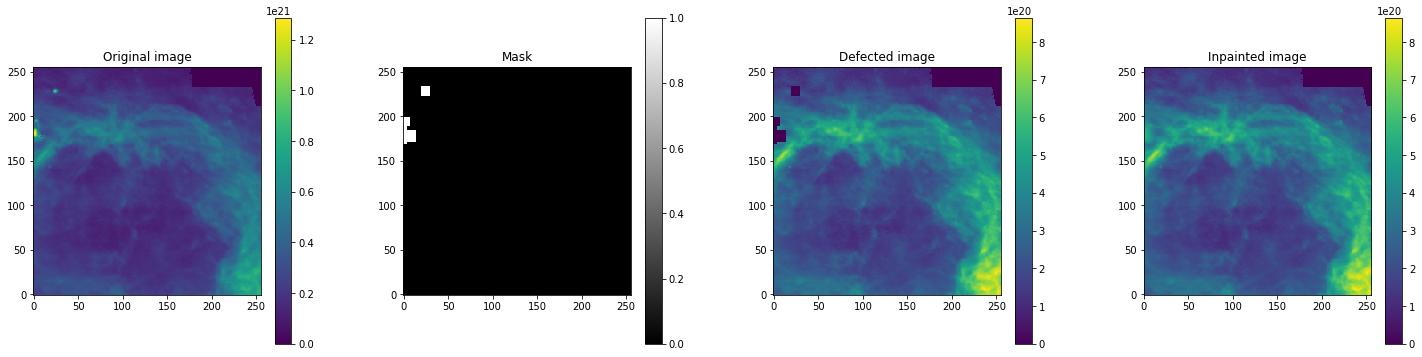

In [19]:
fig = plt.figure(figsize=(25,6))
plt.subplot(1,4,1)
plt.title('Original image')
plt.imshow(np.sum(image_orig.T ,0)*C*dv, origin='lower') ; plt.colorbar()
plt.subplot(1,4,2)
plt.title('Mask')
plt.imshow(mask.T , cmap=plt.cm.gray, origin="lower") ; plt.colorbar()
plt.subplot(1,4,3)
plt.title('Defected image')
plt.imshow(np.sum(image_defect.T , 0)*C*dv, origin='lower') ; plt.colorbar()
plt.subplot(1,4,4)
plt.title('Inpainted image')
plt.imshow(np.sum(image_result.T , 0)*C*dv,origin='lower') ; plt.colorbar() 
plt.subplots_adjust(wspace=0.3)
fig.savefig("Process_of_inpainting.pdf", bbox_inches="tight")

In [15]:
new_subcube_inpaint = image_result.T

Channel =  240


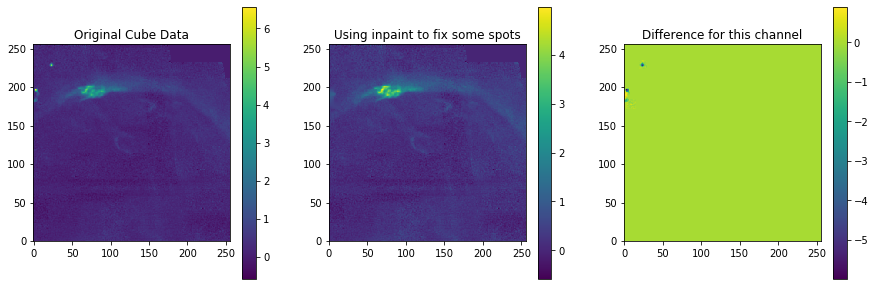

In [16]:
fig = plt.figure(figsize=(15,5))
chan = 240
print("Channel = ", chan)
plt.subplot(1,3,1) ; plt.title("Original Cube Data")
plt.imshow(subcube_NCPL[chan], origin='lower'); plt.colorbar()
plt.subplot(1,3,2) ; plt.title("Using inpaint to fix some spots")
plt.imshow(new_subcube_inpaint[chan], origin="lower") ; plt.colorbar()
plt.subplot(1,3,3) ; plt.title("Difference for this channel")
plt.imshow(new_subcube_inpaint[chan] - subcube_NCPL[chan], origin="lower") ; plt.colorbar()
#plt.imshow(np.sum(new_cube_inpaint, 0) - np.sum(cube, 0), origin="lower") ; plt.colorbar()
plt.subplots_adjust(wspace=0.2)
fig.savefig("Cube_data_vs_Inpainting.pdf", bbox_inches="tight")

From this difference we see the data has been modified only at the areas of interest and no changes anywhere else. In this channel, we can see the galaxy region go away and the map in the middle is still nice and smooth.

## Write out to .fits file

In [17]:
#new_hdr = fits.Header()
new_hdr = hdr
new_hdr["NAXIS2"] = 256
new_hdr["NAXIS3"] = 256

In [18]:
empty_primary = fits.PrimaryHDU(_______, header=new_hdr)

hdulist = fits.HDUList([empty_primary])
hdulist.writeto("GHIGLS_NCPL_Tb_INPAINTED_SUBCUBE.fits", clobber=True)

NameError: name '_______' is not defined